## Numba

``` Numba translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. The compiled code is executed directly by the processor. 
Numba compiles individual python functions just-in-time, or as you need them
Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN. ```

### How Numba works

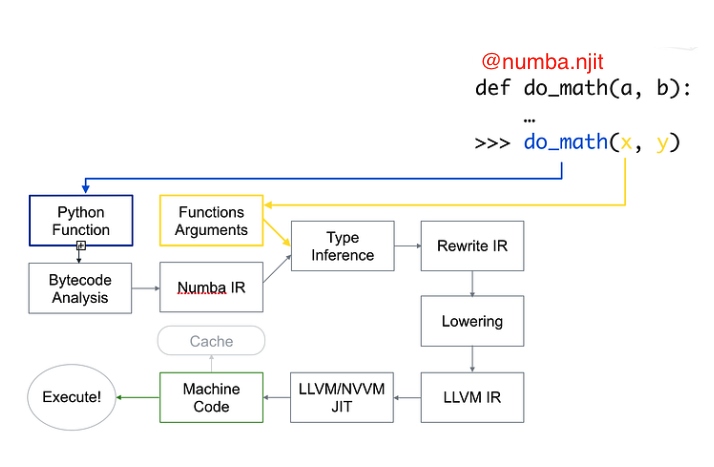

In [ ]:
import numpy as np
import numba
import time
import matplotlib.pyplot as plt

``` You don't need to replace the Python interpreter, run a separate compilation step, or even have a C/C++ compiler installed. ``` 

**Just apply one of the Numba decorators to your Python function, and Numba does the rest.**

## What can you use numba on?

If your code is numerically orientated (does a lot of math), uses NumPy a lot and/or has a lot of loops, then Numba is often a good choice.

* Numba likes loops
* Numba likes math
* Numba likes numpy functions

***OK***: tuples, strings

***Not good***: objects, Python lists, python dicts

### Example 1

In [ ]:
def go_fast(a):
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

In [ ]:
x = np.arange(100).reshape(10, 10)

In [ ]:
plaintime = %timeit -n 10000 -o go_fast(x)

In [ ]:
@numba.njit
def numba_go_fast(a):
    trace = 0.0
    for i in range(a.shape[0]):   
        trace += np.tanh(a[i, i]) 
    return a + trace             

In [ ]:
jittedtime = %timeit -n 10000 -o numba_go_fast(x)

In [ ]:
plaintime.best/jittedtime.best

Why is there a slow run?
```
Numba has to compile your function for the argument types given before it executes the machine code version of your function. This takes time. 

However, once the compilation has taken place Numba caches the machine code version of your function for the particular types of arguments presented. If it is called again with the same types, it can reuse the cached version instead of having to compile again.
```

In [ ]:
x = np.arange(10000).reshape(100, 100)

In [ ]:
@numba.njit
def numba_go_fast(a):
    trace = 0.0
    for i in range(a.shape[0]):   
        trace += np.tanh(a[i, i]) 
    return a + trace             

# COMPILATION TIME!
start = time.perf_counter()
numba_go_fast(x)
end = time.perf_counter()
print("Elapsed (with compilation) = %0.5fs" %(end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.perf_counter()
numba_go_fast(x)
end = time.perf_counter()
print("Elapsed (after compilation) = %0.5fs" %(end - start))

start = time.perf_counter()
go_fast(x)
end = time.perf_counter()
print("Elapsed (without numba) = %0.5fs" %(end - start))

### Example 2

In [ ]:
def estimate_pi(n):
    count_inside_circle = 0

    for _ in range(n): #Numba likes loops
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        
        if x**2 + y**2 <= 1:
            count_inside_circle += 1
    
    pi_estimate = 4 * count_inside_circle / n #Numba likes math
    return pi_estimate

In [ ]:
# Call the function and print the estimated value of pi
n = [10, 1000, 10000, 100_000, 1_000_000]
for i in n:
    pi_estimate = estimate_pi(i)
    print("Estimated Pi: %0.2f" %pi_estimate)

In [ ]:
%timeit estimate_pi(100_000)

In [ ]:
@numba.njit
def numba_estimate_pi(n):
    count_inside_circle = 0

    for _ in range(n): #Numba loves loops
        x = np.random.uniform(-1, 1) #Numba loves numpy functions 
        y = np.random.uniform(-1, 1)
        
        if x**2 + y**2 <= 1:
            count_inside_circle += 1
    
    pi_estimate = 4 * count_inside_circle / n #Numba loves math
    return pi_estimate

In [ ]:
%timeit -n 10 numba_estimate_pi(1_000_000)

## What does numba *not* do?
* Magically make individual numpy functions faster, or speed up code that just has nice array operations
* Convert aribitrary python data types
* Translate entire programs
* Compile third party libraries
* Numba cannot help speed up algorithms that are not primarily numerical (for instance object-oriented programs)
* If you need to interface to C++

### Example 1

In [ ]:
a = np.random.normal(0, 1, 100_000)

In [ ]:
def just_sum(a):
    result = 0
    for i in range(a.shape[0]):
        result += a[i]
    return result
forlooptime = %timeit -n 10 -r 5 -o just_sum(a)

In [ ]:
def numpy_sum(a):
    return np.sum(a)
numpytime = %timeit -n 10 -r 5 -o numpy_sum(a)

In [ ]:
np.testing.assert_allclose(just_sum(a), numpy_sum(a))

In [ ]:
@numba.njit
def just_sum(a):
    result = 0
    for i in range(a.shape[0]):
        result += a[i]
    return result
just_sum(a)

In [ ]:
jittedforlooptime = %timeit -n 10 -r 5 -o just_sum(a)

In [ ]:
@numba.njit
def numpy_sum(a):
    return np.sum(a)
numpy_sum(a)

In [ ]:
jittednumpytime = %timeit -n 10 -r 5 -o numpy_sum(a)

In [ ]:
for i in [forlooptime, numpytime, jittedforlooptime, jittednumpytime]:
    print(i)

### Example 3

In [ ]:
x = np.arange(100).reshape(10, 10)
def go_numpy(a):
    return a + np.tanh(np.diagonal(a)).sum()

In [ ]:
np.testing.assert_allclose(go_fast(x), go_numpy(x))

In [ ]:
numpytime = %timeit -n 10 -o go_numpy(x)

In [ ]:
for i in [plaintime, numpytime, jittedtime]:
    print(i)

### Example 2

``` @njit stands for @jit(nopython=True) and it means that numba should throw an exception instead of falling back to the python version, in cases where it cannot generate the optimized version. ```

In [ ]:
import pandas as pd

x = {'a': [1, 2, 3], 'b': [20, 30, 40]}

@numba.njit
def use_pandas(a): # Function will not benefit from Numba jit
    df = pd.DataFrame.from_dict(a) # Numba doesn't know about pd.DataFrame
    df += 1                        # Numba doesn't understand what this is
    return df.cov()                # or this!

print(use_pandas(x))

## Quick exercise

The function below maps all sample values of a 1D array below a certain absolute threshold magnitude to zero.

```
Convert this code to speed up using numba. Use timeit to benchmark.
```

hint: replace some numpy functions with loops

In [ ]:
def numpy_zero_suppression(values, threshold):
    cond = np.less(np.abs(values), threshold)
    return np.where(cond, 0, values)

In [ ]:
@numba.njit
def numba_zero_suppression(values, threshold):
    # Your code here
    for i in range(values.shape[0]):
        if np.abs(values[i])< threshold:
            values[i] = 0
    return values

In [ ]:
x = np.arange(100)
np.testing.assert_array_equal(numpy_zero_suppression(x, 5), numba_zero_suppression(x, 5))

In [ ]:
%timeit -n 100 numba_zero_suppression(x, 5)

In [ ]:
%timeit -n 100 numpy_zero_suppression(x, 5)